### <span style="color:#4f6da9">Дифференциальная эволюция:</span> <span style="color:#0bb79a">неградиентный поиск минимума функции</span>

In [1]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
import numpy as np
import random
import copy

In [2]:
def polar2dec(v, phi, theta):
    """Функция переводит полярные координаты в декартовы"""
    return np.array([v * np.cos(phi) * np.cos(theta),
                     v * np.sin(phi) * np.cos(theta),
                     v * np.sin(theta)])

def diff_evolve_sample(j: int, func: any, v, target_p, comp_index: list,
                       chance: float = 0.5, f: float = 1., *args):
    args = args[0]
    mutant = v[comp_index[0]].copy() + f * (v[comp_index[1]] - v[comp_index[2]])
    for i in range(len(mutant)):
        if random.uniform(0, 1) < chance:
            mutant[i] = v[j][i].copy()
    target_p = func(v[j], args) if target_p is None else target_p
    target = func(mutant, args)
    v[j] = mutant.copy() if target < target_p else v[j]
    target_p = target if target < target_p else target_p
    return np.append(v[j], target_p)

def diff_evolve(func: any, search_domain: list, vector_3d: bool = False, *args, **kwargs):
    """Читай https://ru.wikipedia.org/wiki/Дифференциальная_эволюция
    :param func: Целевая функция
    :param search_domain: 2-мерный список разброса вектора аргументов: [[v[0]_min, v[0]_max], [v[1]_min, v[1]_max],...]
    :param vector_3d: bla bla bla
    :return: v_best: len_vec-мерный список"""
    chance = 0.5 if 'chance' not in kwargs.keys() else kwargs['chance']
    f = 1. if 'f' not in kwargs.keys() else kwargs['f']
    n_vec = 10 if 'n_vec' not in kwargs.keys() else kwargs['n_vec']
    len_vec = 3 if 'len_vec' not in kwargs.keys() else kwargs['len_vec']
    n_times = 5 if 'n_times' not in kwargs.keys() else kwargs['n_times']
    multiprocessing = True if 'multiprocessing' not in kwargs.keys() else kwargs['multiprocessing']
    print_process = False if 'print_process' not in kwargs.keys() else kwargs['print_process']
    lst_errors = []
    # попробовать tuple(search_domain[i])
    if vector_3d:
        if len_vec == 3:
            v = np.array([polar2dec(np.exp(random.uniform(np.log(search_domain[0]), np.log(search_domain[1]))),
                                    random.uniform(0, 2 * np.pi),
                                    random.uniform(- np.pi / 2, np.pi / 2)) for _ in range(n_vec)])
        else:
            v = np.array([np.append(polar2dec(np.exp(random.uniform(np.log(search_domain[0]), np.log(search_domain[1]))),
                                              random.uniform(0, 2 * np.pi), random.uniform(- np.pi / 2, np.pi / 2)),
                                    [random.uniform(search_domain[2], search_domain[3])
                                     for _ in range(len_vec - 3)]) for _ in range(n_vec)])
    else:
        v = np.array([np.array([random.uniform(search_domain[i][0], search_domain[i][1]) for i in range(len_vec)])
                      for _ in range(n_vec)])
    v_record = [copy.deepcopy(v)]
    target_prev = [None for _ in range(n_vec)]
    v_best = None
    for i in range(n_times):
        if print_process:
            print(Fore.CYAN + f"Шаг {i + 1}/{n_times} дифференциальной эволюции" + Style.RESET_ALL)
        comp_index = [[] for _ in range(n_vec)]
        for j in range(n_vec):
            complement = list(range(n_vec))
            complement.remove(j)
            for _ in range(3):
                comp_index[j].append(random.choice(complement))
                complement.remove(comp_index[j][len(comp_index[j]) - 1])
        anw = p_map(diff_evolve_sample,
                    [j for j in range(n_vec)],
                    [func for _ in range(n_vec)],
                    [v for _ in range(n_vec)],
                    [target_prev[j] for j in range(n_vec)],
                    [comp_index[j] for j in range(n_vec)],
                    [chance for _ in range(n_vec)],
                    [f for _ in range(n_vec)],
                    [args for _ in range(n_vec)]) if multiprocessing else \
            [diff_evolve_sample(j, func, v,
                                target_prev[j],
                                comp_index[j],
                                chance, f, args) for j in range(n_vec)]
        v = np.array([np.array(anw[j][0:len_vec]) for j in range(n_vec)])
        v_record += [copy.deepcopy(v)]
        target_prev = [anw[j][len_vec] for j in range(n_vec)]
        lst_errors.append(np.min(target_prev))
        v_best = v[np.argmin(target_prev)]
    if print_process:
        print(Fore.MAGENTA + f"Ошибка: {lst_errors}" + Style.RESET_ALL)
        print(Fore.MAGENTA + f"Ответ: {v_best}" + Style.RESET_ALL)
    return v_best, v_record, lst_errors

In [3]:
def Plot_DiffEvolve_ShowCase(func):
    v_bounds = [[-10., 10.], [-10., 10.]]
    r, r_rec, losses = diff_evolve(func, v_bounds, False, 0.3, n_vec=25, chance=0.1, f=0.8, len_vec=2, n_times=15, multiprocessing=False, print_process=False)

    plt.plot(range(len(losses)), losses, c='navy')
    plt.grid(True)
    plt.title("Функция потерь")
    plt.xlabel("Итерации")
    plt.show()
    
    X, Y, Z = axes3d.get_test_data(0.05)
    X = np.arange(v_bounds[0][0], v_bounds[0][1], 0.25)
    Y = np.arange(v_bounds[1][0], v_bounds[1][1], 0.25)
    X, Y = np.meshgrid(X, Y)
    Z = 0.3 * np.sqrt(X**2 + Y**2)
    
    fig, ax = plt.subplots()
    im = ax.imshow(Z, cmap='Blues', alpha=0.5)
    fig.colorbar(im, ax=ax)
    for i in range(len(r_rec[0])):
        for j in range(len(r_rec) - 1):
            plt.plot([r_rec[j][i][0]*4+40, r_rec[j+1][i][0]*4+40], [r_rec[j][i][1]*4+40, r_rec[j+1][i][1]*4+40], 
                     c='purple', alpha=(j+1)/len(r_rec))
    plt.show()
    
    ax = plt.figure().add_subplot(projection='3d')
    ax.plot_surface(X, Y, Z, edgecolor='royalblue', lw=0.5, rstride=8, cstride=8, alpha=0.3)
    plt.show()

In [4]:
def Plot_DiffEvolve_ShowCase(func):
    v_bounds = [[-10., 10.], [-10., 10.]]

    r, r_rec, losses = diff_evolve(func, v_bounds, False, 0.3, n_vec=25, chance=0.1, f=0.8, len_vec=2, n_times=15, multiprocessing=False, print_process=False)

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    
    ax[0].plot(range(len(losses)), losses, c='navy')
    ax[0].grid(True)
    ax[0].set_title("Функция потерь")
    ax[0].set_xlabel("Итерации")
    
    X, Y, Z = axes3d.get_test_data(0.05)
    X = np.arange(v_bounds[0][0], v_bounds[0][1], 0.25)
    Y = np.arange(v_bounds[1][0], v_bounds[1][1], 0.25)
    X, Y = np.meshgrid(X, Y)
    # Z = 0.3 * np.sqrt(X**2 + Y**2)
    # Z = 0.3 * np.sqrt(X**2 + Y**2) - np.cos(X) - np.cos(Y)
    Z = np.array([[func([X[i, j], Y[i, j]], (0.3, )) for i in range(len(X))] for j in range(len(Y))])
    
    im = ax[1].imshow(Z, cmap='Blues', alpha=0.5)
    for i in range(len(r_rec[0])):
        for j in range(len(r_rec) - 1):
            ax[1].plot([r_rec[j][i][0]*4+40, r_rec[j+1][i][0]*4+40], [r_rec[j][i][1]*4+40, r_rec[j+1][i][1]*4+40], 
                     c='purple', alpha=(j+1)/len(r_rec))
    ax[1].set_xlim(0, len(X))
    ax[1].set_ylim(0, len(Y))
    ax[1].set_title("Траектории мутантных векторов")

    ax[2].axis('off')
    axs = fig.add_subplot(1, 3, 3, projection='3d')
    axs.plot_surface(X, Y, Z, edgecolor='royalblue', lw=0.5, rstride=8, cstride=8, alpha=0.3)
    axs.set_title("Целевая функция")
    plt.show()

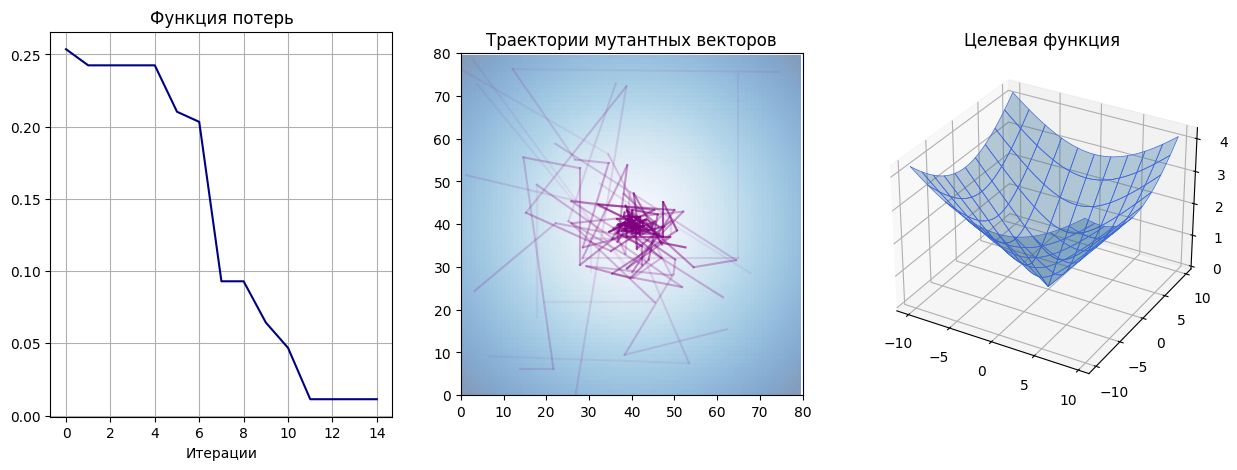

In [5]:
def func(v: list, args):
    """Просто функция просто для иллюстрации алгоритма"""
    coeff, = args
    return  coeff * np.linalg.norm(v)

Plot_DiffEvolve_ShowCase(func)

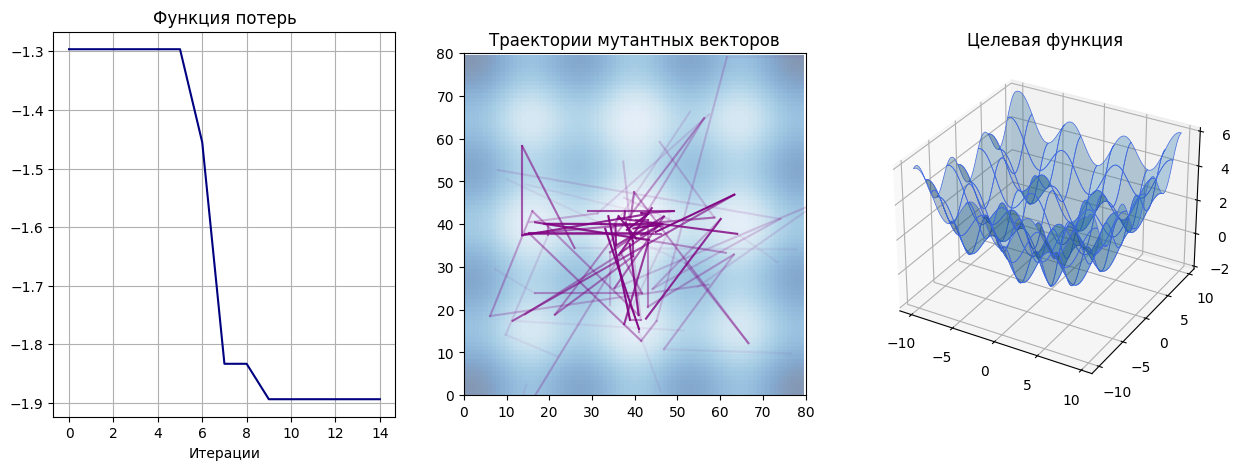

In [6]:
def func2(v: list, args):
    """Просто функция просто для иллюстрации алгоритма"""
    coeff, = args
    return  coeff * np.linalg.norm(v) - np.cos(v[0]) - np.cos(v[1])

Plot_DiffEvolve_ShowCase(func2)